# Lab 6: Convolutional Neural Networks


**Name(s):** Luke Voinov, Tiffany Nguyen, Emmanuel Garcia, Nimai Keshu

We use the Youtube Thumbnail Dataset:

https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset/data

This dataset contains the most successful thumbnails from over 90 youtube channels. There are 9 genres of videos with 10 - 15 channels in each genre

Much of the code in this dataset was adapted from Eric Larson, 12a. More Advanced CNN Techniques as TFData.ipynb:

https://github.com/eclarson/MachineLearningNotebooks/blob/master/12a.%20More%20Advanced%20CNN%20Techniques%20as%20TFData.ipynb

We denote this reference with (1)

### 1. Pre-processing

In [1]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)
# Python: 3.12.3

Pandas: 2.2.2
Numpy: 2.0.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!find "/content/drive" -maxdepth 7 -type d -iname "thumbnails"

/content/drive/MyDrive/test/thumbnails
/content/drive/.Encrypted/MyDrive/test/thumbnails


In [4]:
# This code was written by Github Copilot to get all the videos into one forlder for convenience
# Change the path and output path. make sure the input path goes into the images folder so that it could look through each folder inside it.
# Use the ouput path "all_images" for processing. Use the metadata.csv to pair each video with its genre.

import os
import shutil

#path = r"/Users/tiffany/Desktop/CS 5324/Lab 6 - CNNs/thumbnails/images"
#all_videos_path = r"/Users/tiffany/Desktop/CS 5324/Lab 6 - CNNs/all_videos"
path = '/content/drive/My Drive/test/thumbnails/images'
all_videos_path = '/content/drive/My Drive/test/all_videos'

# Create the folder if it doesn't exist
if not os.path.exists(all_videos_path):
    os.makedirs(all_videos_path)

if len(os.listdir(all_videos_path)) == 0:
    total_copied = 0
    seen_filenames = set()

    # Iterate through each subfolder in the path
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        # Only process if it's a directory
        if os.path.isdir(folder_path):
            # Get all files in this subfolder
            for file_name in os.listdir(folder_path):
                source_file = os.path.join(folder_path, file_name)

                # Only copy files, not subdirectories
                if os.path.isfile(source_file):
                    # Check if we've seen this filename before
                    if file_name in seen_filenames:
                        # Handle duplicate by adding folder prefix
                        name, ext = os.path.splitext(file_name)
                        new_file_name = f"{folder_name}_{file_name}"
                        destination_file = os.path.join(all_videos_path, new_file_name)
                        seen_filenames.add(new_file_name)
                    else:
                        destination_file = os.path.join(all_videos_path, file_name)
                        seen_filenames.add(file_name)

                    shutil.copy2(source_file, destination_file)
                    total_copied += 1

    print(f"Successfully copied {total_copied} files to:")
    print(f"{all_videos_path}")
else:
    print("all_videos already populated, skipping copy.")


all_videos already populated, skipping copy.


In [5]:
# this code is adapted from voinv_lab2.ipynb
# This code will list through every image in my folder and put it into a numpy array

import os
import numpy as np
from PIL import Image

# 'all' because there is no need to split between training and testing
source_dir = "/content/drive/My Drive/test/all_videos"

# This code looks inside my 'all' folder and finds all my images
files = sorted(os.listdir(source_dir))
print(f"Loading {len(files)} images as numpy arrays...")

# Load all images into a list of numpy arrays
images = []
for f in files:
    fpath = os.path.join(source_dir, f) # this allow me to access each image path to store each image as an array
    img_array = np.array(Image.open(fpath))
    images.append(img_array)

# Convert list to numpy array
images = np.array(images)
print(f"Loaded {len(images)} images")
print(f"Image array shape: {images.shape}")

Loading 1930 images as numpy arrays...
Loaded 1930 images
Image array shape: (1930, 720, 1280, 3)


In [6]:
# Code adapted from voinov_lab2.ipynb to scale image size down
# Adapted from github copilot to inlucde color channels
# Lareg images take longer to process
# We originally reduce each image to 64x64 and keep the color
# This code first reduces the pixel resolution of each image and then flattens each image

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

start_time = time.time()

# Get image dimensions from first image
print(f"Original image size: {images[0].shape}")

# convert to 32x32 pixels (RGB channels preserved automatically)
target_size = (64, 64)  # width, height only
print(f"Downsampling to: {target_size} (with 3 color channels)")

# number of features when flattened (64 * 64 * 3)
n_features = target_size[0] * target_size[1] * 3

# create a zero matrix that will store each image (rows) and has enough columns to store the number of features when each image is flattened
X = np.zeros((len(images), n_features), dtype=np.float32)

for i in range(len(images)):
    img = images[i]

    # Convert to RGB if image is grayscale or has alpha channel
    img_pil = Image.fromarray(img.astype(np.uint8))
    if img_pil.mode != 'RGB':
        img_pil = img_pil.convert('RGB')

    # resize to 32x32 (keeps 3 RGB channels)
    img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float32) / 255.0

    # each row stores the flattened array (32*32*3 = 3072 features)
    X[i] = img_array.flatten()

h, w = target_size  # Set dimensions for later use
end_time = time.time()
print(f"\nProcessing completed in {end_time - start_time:.2f} seconds")
print(f"Dataset shape: {X.shape}")
print(f"Each image is {h}x{w}x3 = {n_features} features")

Original image size: (720, 1280, 3)
Downsampling to: (64, 64) (with 3 color channels)

Processing completed in 26.37 seconds
Dataset shape: (1930, 12288)
Each image is 64x64x3 = 12288 features


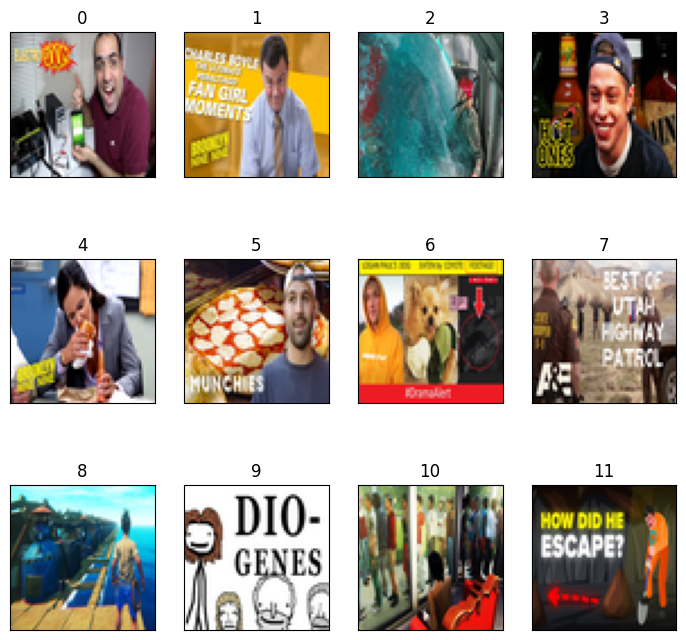

In [7]:
# Code adapted from voinov_lab2.ipynb to plot 12 images from our dataset

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of thumbnails"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Reshape to (h, w, 3) for color
        plt.imshow(images[i].reshape((h, w, 3)))
        plt.title(i, size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # Note that X uses the 32x32 image resolution


2.1 *Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Mention why the data is similar to CIFAR and CIFAR's excellent business case (there isn't one). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*


YouTube could use this dataset to automatically classify youtube videos by genre. Social media companies are always trying to make their recommendation algorithms better. If the algorithm could know the particular genres a user preferred, it could dramatically narrow down which videos it should recommend to the user. Thumbnails, along with other features of a video such as title and creator, would provide enough information about a video's genre. While this dataset does provide each thumbnail's content creator and title, for the purposes of this lab we will just look at how thumbnails (X) can be used to predict genre (y). Furthermore, using this information to classify genres is recommended because user will only click on a video if the thumbnail, content creator, and title are appealing. Thus, a recommendation system trained on these features would see things close to how a user sees them; it would be close to the real-life context.

Rather than just choosing a metric based off our expectations, we will think through which one might be better and test all of them to make sure.

The CNN would say the following about accuracy: "out of all the videos I was given, I classified this percentage as the correct genre". Thus, a score of 0.9 would mean that the CNN was able to classify 90% of the videos to their respective genres. This measurement could be meaningful. Because there are 9 genres in this dataset, class imbalance wouldn't be too large of an issue. If our CNN classified each video as only one genre, it would get a max accuracy of 1/9 = 11.1%. If it classified videos into 8 genres and ignored one completely, it could get near 90% accuracy. This wouldn't be too bad.

Precision would tell us how many videos belong to the genre they were classified to. For every video classified into the entertainment genre, how many are actually entertainment? This means that precision would help us detect how many false positives there are in the data. Recall does the opposite and helps us predict how mnay false negatives there are.

Now it remains to consider what this system want to achieve and what conditions it should strive to avoid. The goal of this system is to correctly classify each thumbnail to its genre. Would it matter too much if the CNN incorrectly classified one genre (cooking, say) as a different one (gaming, say)? This would be an example of a false positive. If a user preferred gaming videos, and, while looking at their recommendations, saw a cooking video, would this be too harmful? Not at all, as long as the system classifies the majority of the thumbnails as 'gaming' and this cooking video is an outlier. At an extreme, however, the user would be severely dissatisfied if the system recommended mainly cooking videos. Therefore false positives should be punished to the extent that they're only rarely classified as such.

Would it matter if a 'gaming' video was consistently misclassified as non-gaming? This would be a false negative. That would mean that the user would never see that video from recommendations alone. This is a greater problem as it could have fueled greater engagement. While recommending the occassional cooking video could allow the system to catch changing preferences, the user is more likely to click on videos within their favorite genre. Since this is what the system wants, false negatives should be taken more seriosly than false positives.

Taken together, recall is slighly more important than precision because false negatives are more important to avoid. Precision also plays an important role though. Thus, F_beta would be a good measurement metric since it combines both precision and recall and allows us to weigh one as more imporatant than the other. Here, beta > 1, to give more importance to recall. Beta can be somehting between 2 or 3 because recall shouldn't have too much of an edge over precision.

We choose F_3 and recall as our primary evalutation metrics. We will visualize with confusion matricies.

**2.2 Train & Test Split Dataset**

 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method, as appropriate. Convince me that your splitting method is a realistic mirroring of how an algorithm would be used in practice.

The method that we will be using to divide our data into training and testing is a **stratified shuffle split**. Why? Our dataset contains multiple YouTube categories (some examples include: Science, Entertainment, Gaming, etc.), so a simple random split may create an unbalanced test set, overrepresenting some categories while under-representing some others.

If we use stratification, each category would appear in the training and test sets in the same proportion as the full dataset. No category here is lost or underrepresented in the test set. This is important because thumbnails vary widely across genres. An example, if "Science" videos appeared heavily in he training set but were rarely represented in the test set, the model's generalization performance would be unreliable.

Here, we are doing a 80/20 split (80% training and 20% being testintg), which is common especially with how we are using our dataset. A 20% test set is large enough to evaluate model performance across all categories, hence why we chose this as it provides sufficient training data for learning and sufficient test data for evaluation.

The YouTube thumbnails in the dataset are grouped by channel in the original folder, so we would be required to shuffle the dataset. What shuffling does for us is that it ensures the model sees a more randomized and diverse sample of thumbnails during training, preventing bias due to ordering effects.

This approach of using stratified shuffle split would best reflect how a real Youtube-style classification model would be developed and evaluated in practice.

First, I want to check out this metadata.csv file out. Let's see what it has to provide for us.

In [8]:
# Imported from Github Copilot to help with reading the metadata file

# load metadata
metadata_path = "/content/drive/My Drive/test/thumbnails/metadata.csv"   # change if needed
df = pd.read_csv(metadata_path)

print(df.head())

            Id      Channel Category  \
0  OkmNXy7er84  3Blue1Brown  Science   
1  r6sGWTCMz2k  3Blue1Brown  Science   
2  bBC-nXj3Ng4  3Blue1Brown  Science   
3  aircAruvnKk  3Blue1Brown  Science   
4  HEfHFsfGXjs  3Blue1Brown  Science   

                                               Title  
0            The hardest problem on the hardest test  
1  But what is a Fourier series? From heat flow t...  
2                But how does bitcoin actually work?  
3  But what is a neural network? | Chapter 1, Dee...  
4    The most unexpected answer to a counting puzzle  


I notice 3 columns, the Id, Channel, and the Category! This is going to be good for us so we can see the genres and also see the channels they're coming from.

In [9]:
# Adapted from Github Copilot

files = sorted(os.listdir(source_dir))

# remove extensions so we can match "OkmNXy7er84" to "OkmNXy7er84.jpg"
file_ids = [os.path.splitext(f)[0] for f in files]

y = []
for fid in file_ids:
    # look up category in metadata where Id matches file name (without extension)
    genre = df.loc[df['Id'] == fid, 'Category'].values[0]
    y.append(genre)

y = np.array(y)
print("Labels created. Shape:", y.shape)


Labels created. Shape: (1930,)


Let's finally split the dataset accordingly!

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1544
Test size: 386


Now that it has been split accordingly, we should be prepared to go into Modeling.

### Note from Luke: I cannot yet use the evalutaion metric until y'all get to the 2 point problem on modeling. DO NOT do any evaluations - let me do those.

### 3. Modeling

Prep for CNN modeling

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
X_train_cnn = X_train.reshape(-1, 64, 64, 3)
X_test_cnn = X_test.reshape(-1, 64, 64, 3)
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)
NUM_CLASSES = len(le.classes_)

# MODIFIED with Chat GPT 5
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
ds_train = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_int))
ds_train = ds_train.shuffle(len(X_train_cnn), seed=42).batch(batch_size).prefetch(AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_int))
ds_val = ds_val.batch(batch_size).prefetch(AUTOTUNE)

# Debugging
for images, labels in ds_train.take(1):
    print(labels[:20])
    print(labels.dtype)
print("NUM_CLASSES =", NUM_CLASSES)
all_labels = []
for _, y in ds_train.take(1000):
    all_labels.append(y.numpy())
all_labels = np.concatenate(all_labels)
print("Unique labels:", np.unique(all_labels))
print("Count:", len(np.unique(all_labels)))


tf.Tensor([14  3  8 20 15 15 15  9 10  2 11 14  8  2 15 20 13  2 10  0], shape=(20,), dtype=int64)
<dtype: 'int64'>
NUM_CLASSES = 21
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Count: 21


Data Augmentation

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1, value_range=(0,1)),
    layers.RandomContrast(0.1),
], name="augmentation_block")


(Need to add explanation)

Additional Models

In [13]:
def create_cnn_model(model_name,
                     input_shape=(64,64,3),
                     kernel_size=(3,3),
                     pool_size=(2,2),
                     filters_per_conv_layer=[32],
                     dense_layer_sizes=[128],
                     num_classes=9,
                     use_dropout=False):

    cnn = Sequential(name=model_name)
    cnn.add(Input(input_shape))

    for num_filters in filters_per_conv_layer:
        cnn.add(Conv2D(filters=num_filters,
                       kernel_size=kernel_size,
                       padding='same',
                       activation='relu'))
        cnn.add(MaxPooling2D(pool_size=pool_size))

    cnn.add(Flatten())
    for num_hidden in dense_layer_sizes:
        cnn.add(Dense(num_hidden, activation='relu'))
        if use_dropout:
            cnn.add(Dropout(0.5))

    cnn.add(Dense(num_classes, activation='softmax'))

    return cnn

# create_advanced_cnn generated by ChatGPT
def create_advanced_cnn(model_name="advanced_cnn", input_shape=(64, 64, 3),
                        num_classes=10, data_augmentation=None, kernel_size=(3,3),
                        pool_size=(2,2), residual_filters=32, final_conv_filters=64,
                        dense_hidden_units=128, use_separable=True, use_dropout=True,
                        dropout_rate=0.5):

    ConvLayer = SeparableConv2D if use_separable else Conv2D

    inp = Input(shape=input_shape, name=f"{model_name}_input")
    x = inp

    if data_augmentation is not None:
        x = data_augmentation(x)

    x = Conv2D(residual_filters, kernel_size, padding='same', activation='relu',
               name=f"{model_name}_conv1")(x)
    x = MaxPooling2D(pool_size=pool_size, name=f"{model_name}_pool1")(x)

    res = x

    x = ConvLayer(residual_filters, kernel_size, padding='same', activation='relu',
                  name=f"{model_name}_res_conv_a")(x)
    x = ConvLayer(residual_filters, kernel_size, padding='same', activation='relu',
                  name=f"{model_name}_res_conv_b")(x)

    x = Add(name=f"{model_name}_add")([x, res])
    x = Activation('relu', name=f"{model_name}_add_relu")(x)
    x = MaxPooling2D(pool_size=pool_size, name=f"{model_name}_pool_after_res")(x)

    x = Conv2D(final_conv_filters, kernel_size, padding='same', activation='relu',
               name=f"{model_name}_conv2")(x)
    x = MaxPooling2D(pool_size=pool_size, name=f"{model_name}_pool2")(x)

    x = Flatten(name=f"{model_name}_flatten")(x)
    if use_dropout:
        x = Dropout(dropout_rate, name=f"{model_name}_dropout")(x)

    x = Dense(dense_hidden_units, activation='relu', name=f"{model_name}_dense")(x)
    outputs = Dense(num_classes, activation='softmax', name=f"{model_name}_output")(x)

    model = Model(inputs=inp, outputs=outputs, name=model_name)
    return model

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Concatenate, Add, Reshape, Input
cnn1 = create_cnn_model(
    model_name = "cnn1",
    input_shape = (64,64,3),
    kernel_size = (3,3),
    pool_size   = (2,2),
    filters_per_conv_layer = [32,64],
    dense_layer_sizes      = [128],
    num_classes            = NUM_CLASSES,
    use_dropout            = True
)

cnn2 = create_advanced_cnn(
    model_name = "cnn2",
    input_shape = (64,64,3),
    num_classes = NUM_CLASSES,
    kernel_size = (3,3),
    data_augmentation = data_augmentation,
    residual_filters  = 32,
    final_conv_filters= 64,
    dense_hidden_units= 128,
    use_dropout       = True
)

cnn3 = create_cnn_model(
    model_name = "cnn3",
    input_shape = (64,64,3),
    kernel_size = (3,3),
    pool_size   = (2,2),
    filters_per_conv_layer = [32,64,64],
    dense_layer_sizes      = [128,100],
    num_classes            = NUM_CLASSES,
    use_dropout            = True
)

cnn4 = create_advanced_cnn(
    model_name = "cnn4",
    input_shape = (64,64,3),
    num_classes = NUM_CLASSES,
    kernel_size = (3,3),
    data_augmentation = data_augmentation,
    residual_filters  = 64,
    final_conv_filters= 128,
    dense_hidden_units= 128,
    use_dropout       = True
)

for model in [cnn1, cnn3]:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(beta_1=.9, beta_2=.999, learning_rate=1e-4),
        metrics=['accuracy']
    )
    print(model.summary())
    model.fit(
        ds_train,
        epochs=50,
        verbose=1,
        validation_data=ds_val
    )

for model in [cnn2, cnn4]:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(beta_1=.9, beta_2=.999, learning_rate=1e-4),
        metrics=['accuracy']
    )
    print(model.summary())
    model.fit(
        ds_train,
        epochs=50,
        verbose=1,
        validation_data=ds_val
    )

Model: "cnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,119,381 (8.08 MB)

 Trainable params: 2,119,381 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1041 - loss: 2.9273 - val_accuracy: 0.1347 - val_loss: 2.7516
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1363 - loss: 2.8137 - val_accuracy: 0.2047 - val_loss: 2.6767
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1788 - loss: 2.6913 - val_accuracy: 0.2539 - val_loss: 2.5906
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1967 - loss: 2.6211 - val_accuracy: 0.2927 - val_loss: 2.5295
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2262 - loss: 2.5453 - val_accuracy: 0.3135 - val_loss: 2.4350
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2694 - loss: 2.4788 - val_accuracy: 0.3394 - val_loss: 2.3910
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2985 - loss: 2.3278 - val_accuracy: 0.3212 - val_loss: 2.3650
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3437 - loss: 2.2370 - val_accuracy: 0.3135 - val

Model: "cnn3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 21)             │         2,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,757 (2.27 MB)

 Trainable params: 595,757 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.0475 - loss: 3.0354 - val_accuracy: 0.0699 - val_loss: 2.9338
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0823 - loss: 2.9684 - val_accuracy: 0.1036 - val_loss: 2.8878
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0936 - loss: 2.9275 - val_accuracy: 0.1969 - val_loss: 2.8428
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1099 - loss: 2.8708 - val_accuracy: 0.1710 - val_loss: 2.8083
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1431 - loss: 2.8330 - val_accuracy: 0.1528 - val_loss: 2.7634
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1360 - loss: 2.8220 - val_accuracy: 0.1995 - val_loss: 2.7338
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1419 - loss: 2.8171 - val_accuracy: 0.1995 - val_loss: 2.7413
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1618 - loss: 2.7943 - val_accuracy: 0.1995 - 

Model: "cnn2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn2_input          │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_block  │ (None, 64, 64, 3) │          0 │ cnn2_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_conv1 (Conv2D) │ (None, 64, 64,    │        896 │ augmentation_blo… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool1          │ (None, 32, 32,    │          0 │ cnn2_conv1[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_res_conv_a     │ (None, 32, 32,    │      1,344 │ cnn2_pool1[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_res_conv_b     │ (None, 32, 32,    │      1,344 │ cnn2_res_conv_a[… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_add (Add)      │ (None, 32, 32,    │          0 │ cnn2_res_conv_b[… │
│                     │ 32)               │            │ cnn2_pool1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_add_relu       │ (None, 32, 32,    │          0 │ cnn2_add[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool_after_res │ (None, 16, 16,    │          0 │ cnn2_add_relu[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_conv2 (Conv2D) │ (None, 16, 16,    │     18,496 │ cnn2_pool_after_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool2          │ (None, 8, 8, 64)  │          0 │ cnn2_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_flatten        │ (None, 4096)      │          0 │ cnn2_pool2[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_dropout        │ (None, 4096)      │          0 │ cnn2_flatten[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_dense (Dense)  │ (None, 128)       │    524,416 │ cnn2_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_output (Dense) │ (None, 21)        │      2,709 │ cnn2_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 549,205 (2.10 MB)

 Trainable params: 549,205 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.0941 - loss: 2.9232 - val_accuracy: 0.1606 - val_loss: 2.7299
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1328 - loss: 2.7572 - val_accuracy: 0.1736 - val_loss: 2.6992
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1609 - loss: 2.7203 - val_accuracy: 0.1891 - val_loss: 2.6720
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1852 - loss: 2.7045 - val_accuracy: 0.1839 - val_loss: 2.6441
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1868 - loss: 2.6739 - val_accuracy: 0.1891 - val_loss: 2.6160
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2121 - loss: 2.6285 - val_accuracy: 0.2021 - val_loss: 2.5900
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2325 - loss: 2.5893 - val_accuracy: 0.2150 - val_loss: 2.5814
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2206 - loss: 2.5718 - val_accuracy: 0.191

Model: "cnn4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn4_input          │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_block  │ (None, 64, 64, 3) │          0 │ cnn4_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_conv1 (Conv2D) │ (None, 64, 64,    │      1,792 │ augmentation_blo… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_pool1          │ (None, 32, 32,    │          0 │ cnn4_conv1[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_res_conv_a     │ (None, 32, 32,    │      4,736 │ cnn4_pool1[0][0]  │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_res_conv_b     │ (None, 32, 32,    │      4,736 │ cnn4_res_conv_a[… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_add (Add)      │ (None, 32, 32,    │          0 │ cnn4_res_conv_b[… │
│                     │ 64)               │            │ cnn4_pool1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_add_relu       │ (None, 32, 32,    │          0 │ cnn4_add[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_pool_after_res │ (None, 16, 16,    │          0 │ cnn4_add_relu[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_conv2 (Conv2D) │ (None, 16, 16,    │     73,856 │ cnn4_pool_after_… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_pool2          │ (None, 8, 8, 128) │          0 │ cnn4_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_flatten        │ (None, 8192)      │          0 │ cnn4_pool2[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_dropout        │ (None, 8192)      │          0 │ cnn4_flatten[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_dense (Dense)  │ (None, 128)       │  1,048,704 │ cnn4_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_output (Dense) │ (None, 21)        │      2,709 │ cnn4_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,136,533 (4.34 MB)

 Trainable params: 1,136,533 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1070 - loss: 2.9182 - val_accuracy: 0.1606 - val_loss: 2.7446
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1749 - loss: 2.7357 - val_accuracy: 0.1658 - val_loss: 2.6834
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1764 - loss: 2.6792 - val_accuracy: 0.1813 - val_loss: 2.6360
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1711 - loss: 2.6472 - val_accuracy: 0.1917 - val_loss: 2.5964
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2289 - loss: 2.5692 - val_accuracy: 0.2254 - val_loss: 2.5521
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1992 - loss: 2.5717 - val_accuracy: 0.2150 - val_loss: 2.5281
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2410 - loss: 2.5571 - val_accuracy: 0.1813 - val_loss: 2.6236
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2252 - loss: 2.5512 - val_accuracy: 0.251

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8622 - loss: 0.5292 - val_accuracy: 0.4637 - val_loss: 2.1612
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8399 - loss: 0.5352 - val_accuracy: 0.4611 - val_loss: 2.2040
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8545 - loss: 0.4885 - val_accuracy: 0.4870 - val_loss: 2.1487
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8658 - loss: 0.4972 - val_accuracy: 0.4378 - val_loss: 2.2009
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8632 - loss: 0.4758 - val_accuracy: 0.4767 - val_loss: 2.2126
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8760 - loss: 0.4147 - val_accuracy: 0.4534 - val_loss: 2.2440
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8890 - loss: 0.4231 - val_accuracy: 0.4560 - val_loss: 2.2179
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8943 - loss: 0.4400 - val_accuracy: 0.4611 - val_loss:

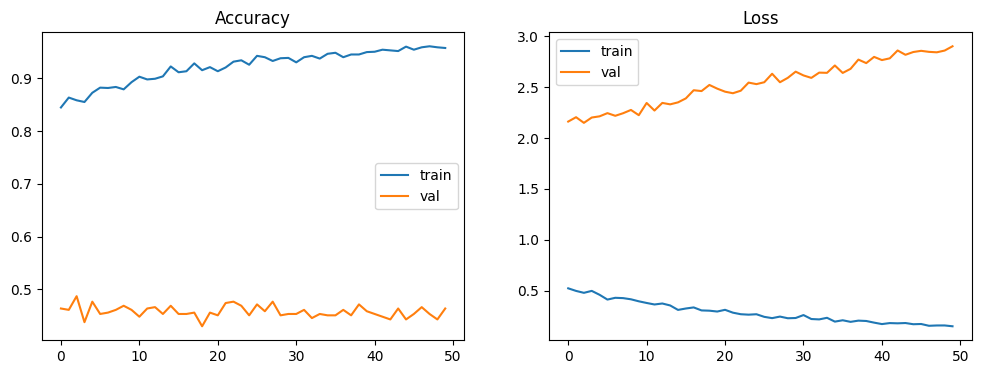

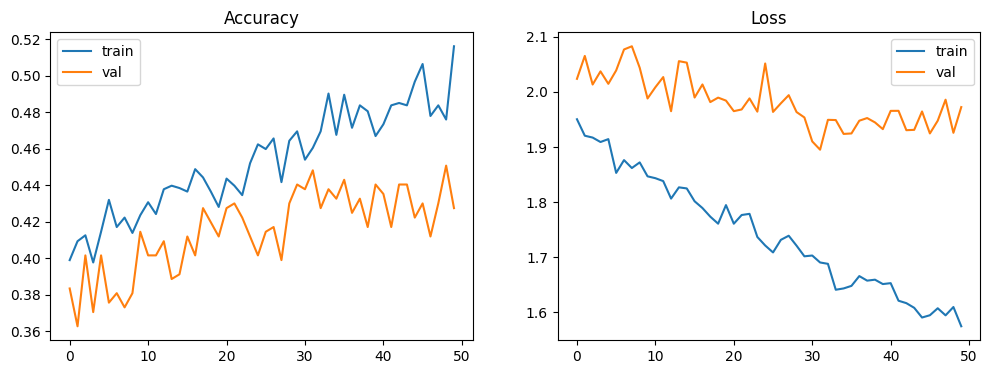

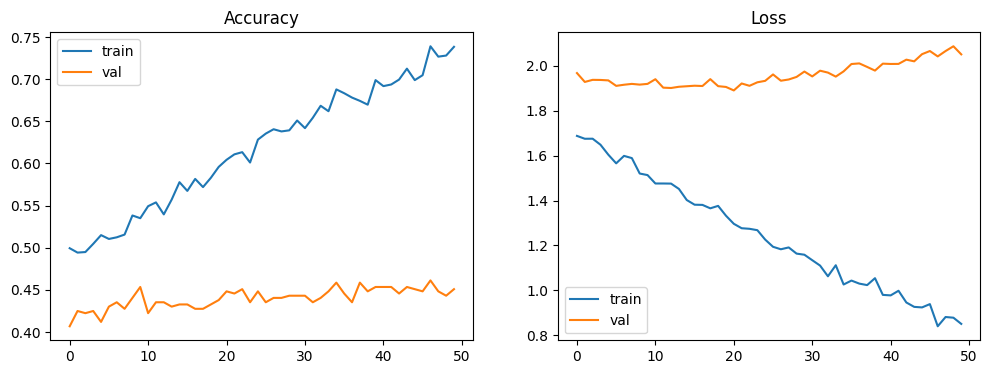

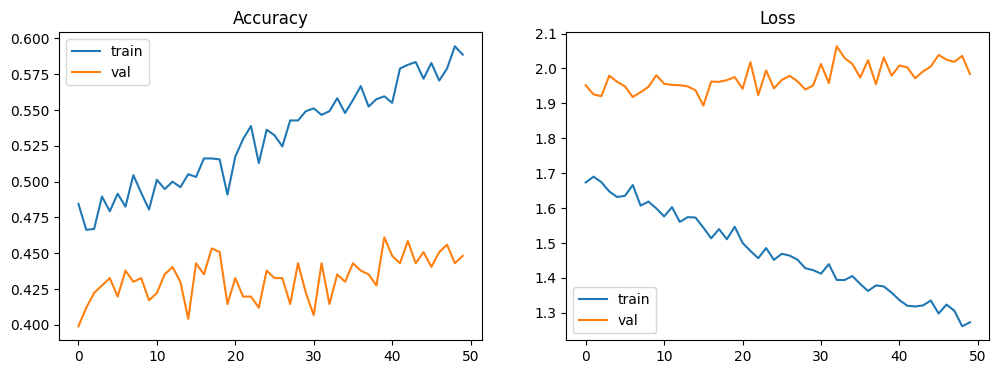

In [15]:
# Plot function generated by GPT
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Loss")
    plt.legend()
    plt.show()

history_cnn1 = cnn1.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
history_cnn3 = cnn3.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
history_cnn2 = cnn2.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
history_cnn4 = cnn4.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
plot_history(history_cnn1)
plot_history(history_cnn2)
plot_history(history_cnn3)
plot_history(history_cnn4)

**Statistical Comparison**

In [16]:
# Statistical comparison code adapted from Claude AI


from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

pred_cnn1 = np.argmax(cnn1.predict(ds_val), axis=1)
pred_cnn2 = np.argmax(cnn2.predict(ds_val), axis=1)
pred_cnn3 = np.argmax(cnn3.predict(ds_val), axis=1)
pred_cnn4 = np.argmax(cnn4.predict(ds_val), axis=1)

y_true = np.concatenate([y for x, y in ds_val], axis=0)

predictions = {
    'CNN1': pred_cnn1,
    'CNN2': pred_cnn2,
    'CNN3': pred_cnn3,
    'CNN4': pred_cnn4
}

bonferroni_alpha = 0.05 / 6

print("="*70)
print("McNemar's Test - Pairwise Model Comparisons")
print("="*70)
print(f"Bonferroni-corrected significance level: α = {bonferroni_alpha:.5f}")
print("="*70)

results = []
for (name1, pred1), (name2, pred2) in combinations(predictions.items(), 2):
    correct_1 = (pred1 == y_true)
    correct_2 = (pred2 == y_true)

    n_both_correct = np.sum(correct_1 & correct_2)
    n_1_only = np.sum(correct_1 & ~correct_2)
    n_2_only = np.sum(~correct_1 & correct_2)
    n_both_wrong = np.sum(~correct_1 & ~correct_2)

    table = [[n_both_correct, n_1_only],
             [n_2_only, n_both_wrong]]

    result = mcnemar(table, exact=True)

    acc1 = np.mean(correct_1)
    acc2 = np.mean(correct_2)

    results.append({
        'comparison': f"{name1} vs {name2}",
        'acc1': acc1,
        'acc2': acc2,
        'diff': acc1 - acc2,
        'p_value': result.pvalue,
        'significant': result.pvalue < bonferroni_alpha,
        'table': table
    })

    print(f"\n{name1} vs {name2}")
    print(f"  {name1} accuracy: {acc1:.4f}")
    print(f"  {name2} accuracy: {acc2:.4f}")
    print(f"  Difference: {acc1 - acc2:+.4f}")
    print(f"  Contingency table:")
    print(f"    Both correct: {n_both_correct}, {name1} only: {n_1_only}")
    print(f"    {name2} only: {n_2_only}, Both wrong: {n_both_wrong}")
    print(f"  p-value: {result.pvalue:.6f}")
    print(f"  Significant (α={bonferroni_alpha:.5f}): {'YES' if result.pvalue < bonferroni_alpha else 'NO'}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"{'Comparison':<20} {'Acc 1':<10} {'Acc 2':<10} {'Diff':<10} {'p-value':<12} {'Sig?'}")
print("-"*70)
for r in results:
    sig_marker = "***" if r['significant'] else ""
    print(f"{r['comparison']:<20} {r['acc1']:<10.4f} {r['acc2']:<10.4f} "
          f"{r['diff']:+<10.4f} {r['p_value']:<12.6f} {sig_marker}")
print("="*70)
print(f"*** = Significant at Bonferroni-corrected α = {bonferroni_alpha:.5f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
McNemar's Test - Pairwise Model Comparisons
Bonferroni-corrected significance level: α = 0.00833

CNN1 vs CNN2
  CNN1 accuracy: 0.4637
  CNN2 accuracy: 0.4275
  Difference: +0.0363
  Contingency table:
    Both correct: 119, CNN1 only: 60
    CNN2 only: 46, Both wrong: 161
  p-value: 0.206498
  Significant (α=0.00833): NO

CNN1 vs CNN3
  CNN1 accuracy: 0.4637
  CNN3 accuracy: 0.4508
  Difference: +0.0130
  Contingency table:
    Both correct: 144, CNN1 only: 35
    CNN3 only: 30, Both wrong: 177
  p-value: 0.620145
  Significant (α=0.00833): NO

CNN1 vs CNN4
  CNN1 accuracy: 0.4637
  CNN4 accuracy: 0.4482
  Difference: +0.0155
  Contingency table:
    Both correct: 126, CNN1 only: 53
    CNN4 only: 47, Both wrong: 160
  p-value: 0.617299
  Significant (α=0.00833): NO

CNN2 vs CNN3
  CNN2 accuracy: 0.4275
  CNN3 accuracy: 0.4508


**CNN vs. MLP**

In [17]:
# Multi-layer perceptron adapted from class lecture/11. Convolutional Neural Networks.ipynb

input_shape = [8,8,1]

mlp = Sequential(name='MLP')
mlp.add( Input(input_shape) )
mlp.add( Flatten() )
mlp.add( Dense( units=30,
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(ds_train,
        batch_size=32, epochs=150,
        shuffle=True, verbose=0)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 64, but received input with shape (None, 12288)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>